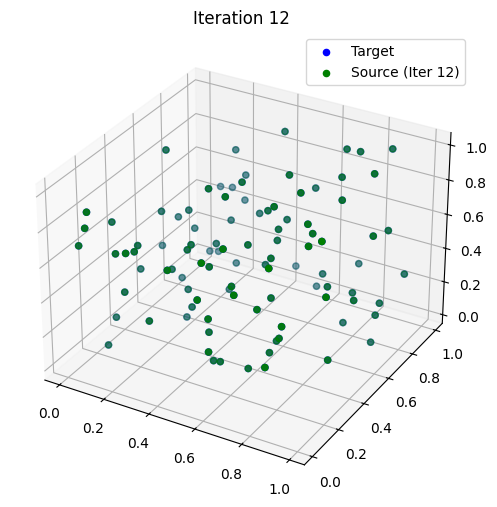

Converged in 12 iterations
Final Transformation Matrix:
[[ 0.98106026  0.08583165 -0.17364818 -0.42126935]
 [-0.02273444  0.94129309  0.33682409  0.09857861]
 [ 0.192364   -0.32649694  0.92541658 -0.43910636]
 [ 0.          0.          0.          1.        ]]


In [5]:
import numpy as np
from scipy.spatial import KDTree
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython import display  # For inline display in Google Colab

# Step 1: Generate sample data (3D point clouds)
np.random.seed(0)

# Target point cloud (original)
target_points = np.random.rand(100, 3)

# Apply a known transformation to generate source points
rotation = R.from_euler('xyz', [20, 10, 5], degrees=True).as_matrix()
translation = np.array([0.5, -0.2, 0.3])
source_points = (rotation @ target_points.T).T + translation

# ICP Parameters
max_iterations = 100
tolerance = 1e-6

def icp(source, target, max_iterations=100, tolerance=1e-6):
    # Initialize transformation matrix (4x4 identity matrix)
    transform = np.eye(4)

    # Iterate ICP
    for i in range(max_iterations):
        # Step 2: Find closest points in the target for each point in the source
        tree = KDTree(target)
        distances, indices = tree.query(source)
        closest_points = target[indices]

        # Step 3: Compute the centroids of source and closest points in target
        source_centroid = np.mean(source, axis=0)
        target_centroid = np.mean(closest_points, axis=0)

        # Center the points around the centroids
        source_centered = source - source_centroid
        target_centered = closest_points - target_centroid

        # Compute the covariance matrix
        H = source_centered.T @ target_centered

        # Singular Value Decomposition (SVD)
        U, S, Vt = np.linalg.svd(H)

        # Compute the rotation matrix
        rotation_matrix = Vt.T @ U.T

        # Fix reflection if necessary
        if np.linalg.det(rotation_matrix) < 0:
            Vt[2, :] *= -1
            rotation_matrix = Vt.T @ U.T

        # Compute the translation vector
        translation_vector = target_centroid - rotation_matrix @ source_centroid

        # Update the transformation matrix
        current_transform = np.eye(4)
        current_transform[:3, :3] = rotation_matrix
        current_transform[:3, 3] = translation_vector
        transform = current_transform @ transform

        # Step 4: Apply transformation to the source points
        source = (rotation_matrix @ source.T).T + translation_vector

        # Visualization for each iteration
        plt.figure(figsize=(8, 6))
        ax = plt.axes(projection='3d')
        ax.scatter(target[:, 0], target[:, 1], target[:, 2], c='blue', label='Target')
        ax.scatter(source[:, 0], source[:, 1], source[:, 2], c='green', label=f'Source (Iter {i+1})')
        ax.legend()
        plt.title(f'Iteration {i+1}')

        # Display the figure and clear output for the next iteration
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.close()  # Close the figure to avoid duplicate outputs

        # Step 5: Check for convergence
        mean_error = np.mean(distances)
        if mean_error < tolerance:
            print(f"Converged in {i + 1} iterations")
            break

    return transform, source

# Run ICP
transformation_matrix, aligned_source = icp(source_points, target_points)

print("Final Transformation Matrix:")
print(transformation_matrix)
